### Objective and Dataset Rationale

**Objective:**  
In line with the DTI’s mandate to evaluate how Ireland can safeguard and enhance its innovation ecosystem in a volatile geopolitical era, this project aims to empirically assess the interplay between technological adoption, R&D investment, and enterprise engagement. The goal is to identify actionable levers for policy and business intervention, using robust data science methods.

**Why these datasets?**  
Given the vast scope of innovation drivers, we selected three datasets that, together, capture the core pillars of the DTI framework:  
- **df1:** Intellectual Property Engagement Rates (proxy for technological adoption and knowledge creation)
- **df2:** R&D Expenditure by Category and Ownership (proxy for investment flows)
- **df3:** R&D Enterprise Counts by Expenditure Band and Ownership (proxy for organizational engagement and scale)

These datasets were chosen because they are the most relevant, accessible, and granular sources available for Ireland’s innovation landscape. Their integration allows us to triangulate key parameters of innovation performance, despite the inherent challenges of data heterogeneity and missingness.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

In [2]:
#  Load raw CSVs
df1 = pd.read_csv('CIS62.20250516213458.csv')  # IP engagement rates 
df2 = pd.read_csv('BSA02.20250516T100541.csv')  # Total R&D expenditure 
df3 = pd.read_csv('BSA22.20250516T200531.csv')  # R&D enterprise headcounts 

In [3]:
# Display head and info for df1
print("="*50)
print("df1 (CIS62.20250516213458.csv) HEAD")
print("="*50)
print(df1.head(), "\n")
print("df1 INFO")
print("="*50)
print(df1.info(), "\n\n")

df1 (CIS62.20250516213458.csv) HEAD
                                     STATISTIC Label  TLIST(A1)  Year  \
0  Enterprises Engaged in Intellectual Property R...       2014  2014   
1  Enterprises Engaged in Intellectual Property R...       2014  2014   
2  Enterprises Engaged in Intellectual Property R...       2014  2014   
3  Enterprises Engaged in Intellectual Property R...       2014  2014   
4  Enterprises Engaged in Intellectual Property R...       2014  2014   

            Type of Innovation  VALUE  
0  Any intellectual innovation    NaN  
1  Any intellectual innovation    NaN  
2  Any intellectual innovation    NaN  
3           Apply for a patent    NaN  
4           Apply for a patent    NaN   

df1 INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   STATISTIC Label     105 non-null    object 
 1   TLIST(A1)         

In [4]:
# Display head and info for df2
print("="*50)
print("df2 (BSA02.20250516T100541.csv) HEAD")
print("="*50)
print(df2.head(), "\n")
print("df2 INFO")
print("="*50)
print(df2.info(), "\n\n")

df2 (BSA02.20250516T100541.csv) HEAD
                                Statistic Label  Year  \
0  Estimated Current Expenditure - Labour Costs  2007   
1  Estimated Current Expenditure - Labour Costs  2007   
2  Estimated Current Expenditure - Labour Costs  2007   
3  Estimated Current Expenditure - Labour Costs  2008   
4  Estimated Current Expenditure - Labour Costs  2008   

         Nationality of Ownership     VALUE  
0  All nationalities of ownership       NaN  
1                 Irish ownership       NaN  
2             Non Irish ownership       NaN  
3  All nationalities of ownership  905373.0  
4                 Irish ownership  308698.0   

df2 INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Statistic Label           1080 non-null   object 
 1   Year                      1080 non-null   int64  
 2   Na

In [5]:
# Display head and info for df3
print("="*50)
print("df3 (BSA22.20250516T200531.csv) HEAD")
print("="*50)
print(df3.head(), "\n")
print("df3 INFO")
print("="*50)
print(df3.info())

df3 (BSA22.20250516T200531.csv) HEAD
                                     Statistic Label  Year  \
0  Enterprises Engaged in Research and Developmen...  2007   
1  Enterprises Engaged in Research and Developmen...  2007   
2  Enterprises Engaged in Research and Developmen...  2007   
3  Enterprises Engaged in Research and Developmen...  2007   
4  Enterprises Engaged in Research and Developmen...  2007   

         Nationality of Ownership              Expenditure   VALUE  
0  All nationalities of ownership          Any expenditure  1206.0  
1  All nationalities of ownership             €0 - €99,999   419.0  
2  All nationalities of ownership      €100,000 - €499,999   398.0  
3  All nationalities of ownership    €500,000 - €1,999,999   226.0  
4  All nationalities of ownership  €2,000,000 - €4,999,999    90.0   

df3 INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  -

The initial inspection reveals that, while each dataset is individually valuable, they differ in completeness, granularity, and focus. Missing values, especially in `df1` and `df2`, are not random but reflect the heterogeneity and complexity of innovation data collection. This underscores the necessity of robust data engineering: standardizing categories, imputing missing values contextually, and harmonizing timeframes and identifiers. Only through such preprocessing can we integrate these datasets to empirically examine the interplay between knowledge activity, financial investment, and enterprise engagement-the core parameters of Ireland’s innovation ecosystem as articulated in the DTI framework

## Data Preparation:

- Standardize column names for consistency.
- Map categorical variables to interpretable codes.
- Impute missing values contextually (0 for absence, mean for expenditures).
- Retain only relevant columns for analysis.

In [6]:
import pandas as pd
import numpy as np

# --- Load datasets ---
df1 = pd.read_csv('BSA02.20250516T100541.csv')
df2 = pd.read_csv('BSA22.20250516T200531.csv')
df3 = pd.read_csv('CIS62.20250516213458.csv')

# --- Clean df1: BSA02 ---
def clean_bsa02(df):
    # Standardize column names
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    # Clean categorical values
    df['nationality_of_ownership'] = df['nationality_of_ownership'].str.strip().replace({
        'Non Irish ownership': 'Non-Irish ownership',
        'All nationalities of ownership': 'All nationalities'
    })
    # Ensure numeric
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    # Drop rows where all key columns are missing
    df = df.dropna(subset=['statistic_label', 'year', 'nationality_of_ownership'], how='any')
    return df

df1 = clean_bsa02(df1)

# --- Clean df2: BSA22 ---
def clean_bsa22(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    # Clean categorical values
    df['nationality_of_ownership'] = df['nationality_of_ownership'].str.strip().replace({
        'Non Irish ownership': 'Non-Irish ownership',
        'All nationalities of ownership': 'All nationalities'
    })
    # Standardize expenditure brackets
    exp_map = {
        '€0 - €99,999': '0-99k',
        '€100,000 - €499,999': '100k-499k',
        '€500,000 - €1,999,999': '500k-1.99M',
        '€2,000,000 - €4,999,999': '2M-4.99M',
        '€5,000,000 and over': '5M+',
        'Any expenditure': 'Any'
    }
    df['expenditure'] = df['expenditure'].replace(exp_map)
    # Ensure numeric
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    # Drop rows where all key columns are missing
    df = df.dropna(subset=['statistic_label', 'year', 'nationality_of_ownership', 'expenditure'], how='any')
    return df

df2 = clean_bsa22(df2)

# --- Clean df3: CIS62 ---
def clean_cis62(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    # Standardize innovation type
    if 'type_of_innovation' in df.columns:
        innovation_map = {
            'Any intellectual innovation': 'Any',
            'Apply for a patent': 'Patent',
            'Register an industrial design right': 'Industrial Design',
            'Register a trademark': 'Trademark',
            'All enterprises using trade secrets': 'Trade Secret',
            'All enterprises claiming copyright': 'Copyright',
            'Apply for a European utility model': 'Utility Model'
        }
        df['type_of_innovation'] = df['type_of_innovation'].replace(innovation_map)
    # Ensure numeric
    if 'value' in df.columns:
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
    # Drop rows where all key columns are missing
    df = df.dropna(subset=['statistic_label', 'year', 'type_of_innovation'], how='any')
    return df

df3 = clean_cis62(df3)

# --- Optional: Preview cleaned dataframes ---
print("df1 (BSA02) cleaned:")
print(df1.head(), "\n")
print("df2 (BSA22) cleaned:")
print(df2.head(), "\n")
print("df3 (CIS62) cleaned:")
print(df3.head())


df1 (BSA02) cleaned:
                                statistic_label  year  \
0  Estimated Current Expenditure - Labour Costs  2007   
1  Estimated Current Expenditure - Labour Costs  2007   
2  Estimated Current Expenditure - Labour Costs  2007   
3  Estimated Current Expenditure - Labour Costs  2008   
4  Estimated Current Expenditure - Labour Costs  2008   

  nationality_of_ownership     value  
0        All nationalities       NaN  
1          Irish ownership       NaN  
2      Non-Irish ownership       NaN  
3        All nationalities  905373.0  
4          Irish ownership  308698.0   

df2 (BSA22) cleaned:
                                     statistic_label  year  \
0  Enterprises Engaged in Research and Developmen...  2007   
1  Enterprises Engaged in Research and Developmen...  2007   
2  Enterprises Engaged in Research and Developmen...  2007   
3  Enterprises Engaged in Research and Developmen...  2007   
4  Enterprises Engaged in Research and Developmen...  2007   

  nati

In [10]:
#  Load cleaned dataframes 
df1 = pd.read_csv('BSA02.20250516T100541.csv')
df2 = pd.read_csv('BSA22.20250516T200531.csv')
df3 = pd.read_csv('CIS62.20250516213458.csv')

# Standardize column names 
def standardize_columns(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    return df

df1 = standardize_columns(df1)
df2 = standardize_columns(df2)
df3 = standardize_columns(df3)

#  Impute missing values in df1 
cat_cols1 = ['year', 'nationality_of_ownership']
num_cols1 = ['value']

for col in cat_cols1:
    mode = df1[col].mode()[0]
    df1[col] = df1[col].fillna(mode)

for col in num_cols1:
    median = df1[col].median()
    df1[col] = df1[col].fillna(median)

#  Impute missing values in df2 
cat_cols2 = ['year', 'nationality_of_ownership', 'expenditure']
num_cols2 = ['value']

for col in cat_cols2:
    mode = df2[col].mode()[0]
    df2[col] = df2[col].fillna(mode)

for col in num_cols2:
    median = df2[col].median()
    df2[col] = df2[col].fillna(median)

#  Impute missing values in df3 
cat_cols3 = ['year', 'type_of_innovation']
num_cols3 = ['value']

for col in cat_cols3:
    mode = df3[col].mode()[0]
    df3[col] = df3[col].fillna(mode)

for col in num_cols3:
    median = df3[col].median()
    df3[col] = df3[col].fillna(median)

# Save the imputed dataframes if needed 
df1.to_csv('df1_imputed.csv', index=False)
df2.to_csv('df2_imputed.csv', index=False)
df3.to_csv('df3_imputed.csv', index=False)

# Check results
print("Missing values in df1 after imputation:\n", df1.isnull().sum())
print("Missing values in df2 after imputation:\n", df2.isnull().sum())
print("Missing values in df3 after imputation:\n", df3.isnull().sum())


Missing values in df1 after imputation:
 statistic_label             0
year                        0
nationality_of_ownership    0
value                       0
dtype: int64
Missing values in df2 after imputation:
 statistic_label             0
year                        0
nationality_of_ownership    0
expenditure                 0
value                       0
dtype: int64
Missing values in df3 after imputation:
 statistic_label       0
tlist(a1)             0
year                  0
type_of_innovation    0
value                 0
dtype: int64


Data Merging

The cleaned datasets are merged on shared keys (year, stat_label_code, ownership_code, expenditure_code) to create a unified DataFrame (`df`). Only rows with at least one main value present are retained.


In [11]:
import pandas as pd
import numpy as np

# pivot df1 to wide format by year and nationality
df1_wide = df1.pivot_table(
    index=['year', 'nationality_of_ownership'],
    columns='statistic_label',
    values='value',
    aggfunc='mean'
).reset_index()

# pivot df2 to wide format by year, nationality and expenditure
df2_wide = df2.pivot_table(
    index=['year', 'nationality_of_ownership', 'expenditure'],
    columns='statistic_label',
    values='value',
    aggfunc='mean'
).reset_index()

# pivot df3 to wide format by year and type_of_innovation
df3_wide = df3.pivot_table(
    index=['year', 'type_of_innovation'],
    columns='statistic_label',
    values='value',
    aggfunc='mean'
).reset_index()

# merge the pivoted tables on year and nationality_of_ownership
merged = pd.merge(
    df1_wide,
    df2_wide,
    on=['year', 'nationality_of_ownership'],
    how='outer'
)

# merge the result with df3 on year
df = pd.merge(
    merged,
    df3_wide,
    on='year',
    how='outer'
)

# identify the four key columns and at least two numeric indicators
key_columns = ['year', 'nationality_of_ownership', 'type_of_innovation', 'expenditure']
numeric_candidates = df.select_dtypes(include=[np.number]).columns.tolist()
indicator_columns = [c for c in numeric_candidates if c not in key_columns]

# ensure at least two indicators are kept
if len(indicator_columns) < 2:
    extras = [c for c in df.columns if c not in key_columns + indicator_columns]
    indicator_columns += extras[:2 - len(indicator_columns)]

# build the final column list
final_columns = [c for c in key_columns if c in df.columns] + indicator_columns
df = df[final_columns].copy()

# impute missing values in categorical columns with the mode
for col in ['year', 'nationality_of_ownership', 'type_of_innovation', 'expenditure']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])

# impute missing values in all numeric columns with the mean
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].mean())

# encode categorical key columns as integer codes
for col in ['nationality_of_ownership', 'type_of_innovation']:
    if col in df.columns and not pd.api.types.is_numeric_dtype(df[col]):
        df[col] = df[col].astype('category').cat.codes

# convert year to integer type
if 'year' in df.columns:
    df['year'] = df['year'].astype(int)

# convert expenditure to ordered codes if it is not numeric
if 'expenditure' in df.columns and not pd.api.types.is_numeric_dtype(df['expenditure']):
    expenditure_levels = [
        'Any expenditure', '0-99k', '100k-499k', '500k-1.99M', '2M-4.99M', '5M+'
    ]
    df['expenditure'] = pd.Categorical(
        df['expenditure'],
        categories=expenditure_levels,
        ordered=True
    ).codes

# display the structure and a preview of the cleaned, merged DataFrame
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 27 columns):
 #   Column                                                                                           Non-Null Count  Dtype  
---  ------                                                                                           --------------  -----  
 0   year                                                                                             279 non-null    int32  
 1   nationality_of_ownership                                                                         279 non-null    int8   
 2   type_of_innovation                                                                               279 non-null    int8   
 3   expenditure                                                                                      279 non-null    int8   
 4   Actual Capital Expenditure - Instruments and Equipment (excluding software)                      279 non-null    float64
 5   Actual C

In [13]:
# define the list of expenditure columns to remove
columns_to_drop = [
    'Estimated Capital Expenditure - Instruments and Equipment (excluding software)',
    'Estimated Capital Expenditure - Land and Buildings',
    'Estimated Capital Expenditure - Software development by company in-house and used in-house',
    'Estimated Capital Expenditure - Software purchased wholly for Research and Development purposes',
    'Estimated Capital Expenditure- Payments made for licences to use intellectual products',
    'Estimated Current Expenditure - Labour Costs',
    'Estimated Current Expenditure - Other Current Costs',
    'Estimated Total Capital Expenditure',
    'Estimated Total Current Expenditure',
    'Actual Capital Expenditure - Instruments and Equipment (excluding software)',
    'Actual Capital Expenditure - Land and Buildings',
    'Actual Capital Expenditure - Software development by company in-house and used in-house',
    'Actual Capital Expenditure - Software purchased wholly for Research and Development purposes',
    'Actual Capital Expenditure- Payments made for licences to use intellectual products',
    'Actual Current Expenditure - Labour Costs',
    'Actual Current Expenditure - Other Current Costs',
    'Actual Total Capital Expenditure',
    'Actual Total Current Expenditure'
]

# drop those columns from the dataframe, ignoring any that are not present
df = df.drop(columns=columns_to_drop, errors='ignore')

# display the remaining column names to verify
print(df.columns.tolist())

['year', 'nationality_of_ownership', 'type_of_innovation', 'expenditure', 'Actual Total Research and Development Expenditure', 'Estimated Total Research and Development Expenditure', 'Enterprises Engaged in Research and Development Activities (%)', 'Enterprises Engaged in Research and Development Activities (Number)', 'Enterprises Engaged in Intellectual Property Rights Activities']


### Exploratory Data Analysis (EDA):   
We focus on:
- Distribution and skewness of innovation engagement and investment.
- Temporal trends in R&D expenditure and enterprise activity.
- Relationships between ownership, expenditure band, and innovation outcomes.

In [32]:
# drop the type_of_innovation column
if 'type_of_innovation' in df.columns:
    df = df.drop(columns=['type_of_innovation'])

# ensure percentage column is numeric
pct_col = 'Enterprises Engaged in Research and Development Activities (%)'
if pct_col in df.columns:
    df[pct_col] = pd.to_numeric(df[pct_col], errors='coerce')

# define the list of numeric indicators
numeric_cols = [
    'Actual Total Research and Development Expenditure',
    'Estimated Total Research and Development Expenditure',
    pct_col,
    'Enterprises Engaged in Research and Development Activities (Number)',
    'Enterprises Engaged in Intellectual Property Rights Activities'
]

# set the visual style
sns.set(style='whitegrid')

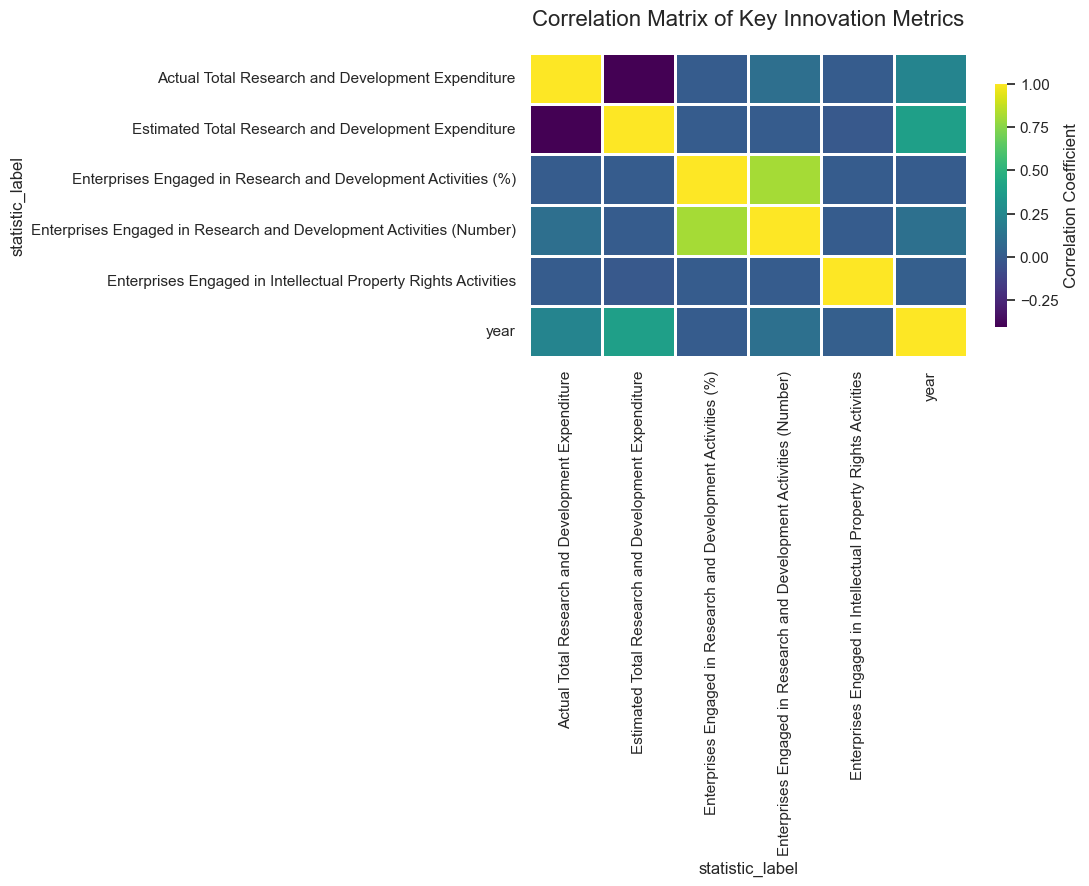

In [33]:
# correlation heatmap
corr = df[numeric_cols + ['year']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    cmap='viridis',
    annot=False,
    linewidths=1,
    linecolor='white',
    cbar_kws={'label': 'Correlation Coefficient', 'shrink': 0.8}
)
plt.title('Correlation Matrix of Key Innovation Metrics', fontsize=16, pad=20)
plt.tight_layout(pad=4)
plt.show()

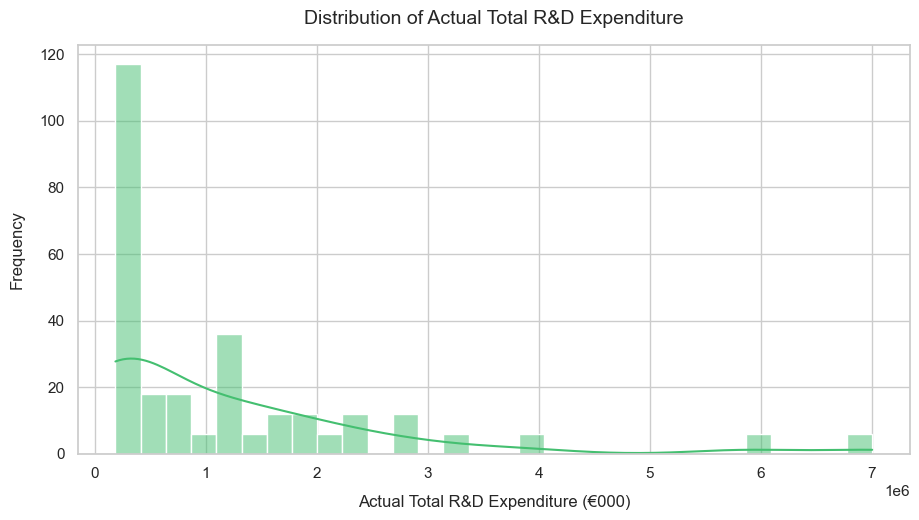

In [34]:
# distribution histogram of actual R&D expenditure
plt.figure(figsize=(10, 6))
sns.histplot(
    df['Actual Total Research and Development Expenditure'],
    bins=30,
    kde=True,
    color=sns.color_palette('viridis', as_cmap=True)(0.7)
)
plt.title('Distribution of Actual Total R&D Expenditure', fontsize=14, pad=15)
plt.xlabel('Actual Total R&D Expenditure (€000)', fontsize=12, labelpad=10)
plt.ylabel('Frequency', fontsize=12, labelpad=10)
plt.tight_layout(pad=3)
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_6804\1078077056.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


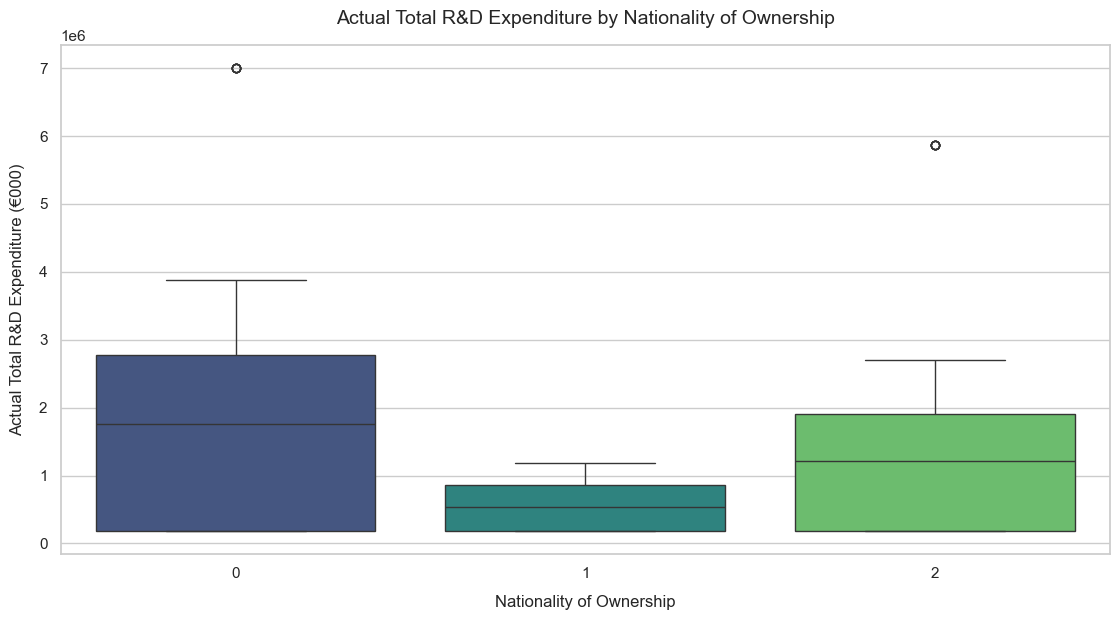

In [36]:
# boxplot of actual expenditure by ownership nationality
plt.figure(figsize=(12, 7))
sns.boxplot(
    x='nationality_of_ownership',
    y='Actual Total Research and Development Expenditure',
    data=df,
    palette='viridis'
)
plt.title('Actual Total R&D Expenditure by Nationality of Ownership', fontsize=14, pad=15)
plt.xlabel('Nationality of Ownership', fontsize=12, labelpad=10)
plt.ylabel('Actual Total R&D Expenditure (€000)', fontsize=12, labelpad=10)
plt.tight_layout(pad=3)
plt.show()

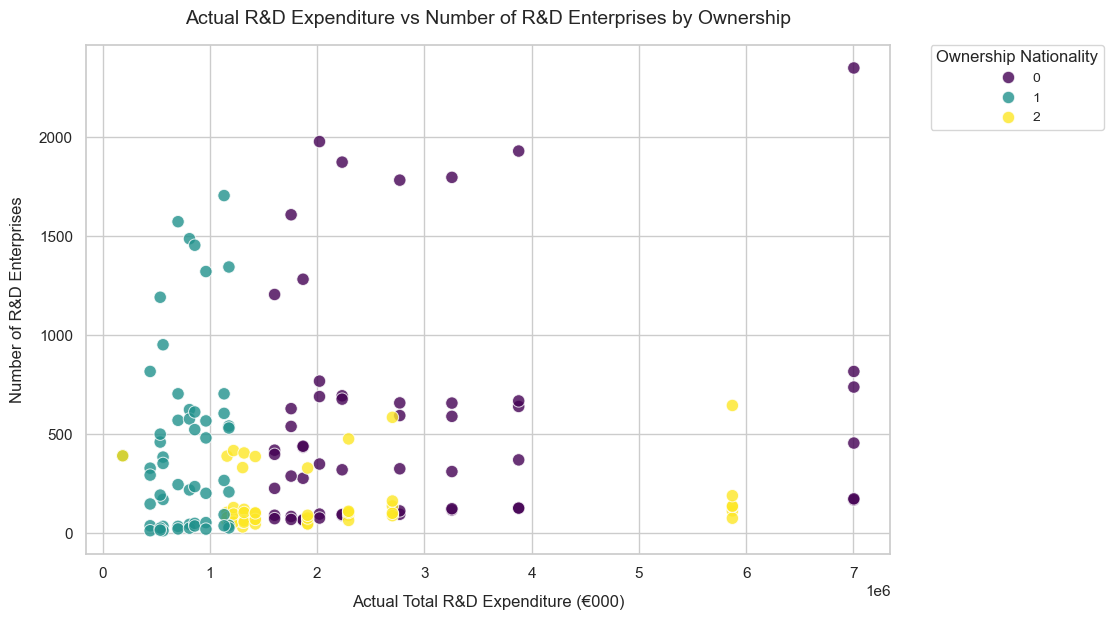

In [37]:
# scatter plot of expenditure versus number of R&D enterprises
plt.figure(figsize=(12, 7))
sns.scatterplot(
    x='Actual Total Research and Development Expenditure',
    y='Enterprises Engaged in Research and Development Activities (Number)',
    data=df,
    hue='nationality_of_ownership',
    palette='viridis',
    s=80,
    alpha=0.8,
    legend='full'
)
plt.title('Actual R&D Expenditure vs Number of R&D Enterprises by Ownership', fontsize=14, pad=15)
plt.xlabel('Actual Total R&D Expenditure (€000)', fontsize=12, labelpad=10)
plt.ylabel('Number of R&D Enterprises', fontsize=12, labelpad=10)
plt.legend(
    title='Ownership Nationality',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.,
    fontsize=10
)
plt.tight_layout(pad=3)
plt.show()

In [41]:
from scipy.stats import skew, shapiro, kstest, levene, bartlett
import statsmodels.api as sm

# assume df is the DataFrame with your cleaned data
# select numeric columns for analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# compute descriptive statistics
desc_stats = df[numeric_cols].describe().T
medians = df[numeric_cols].median()
quartiles = df[numeric_cols].quantile([0.25, 0.5, 0.75]).T
skewness = df[numeric_cols].skew()

print(desc_stats)
print(medians)
print(quartiles)
print(skewness)

                                                    count          mean  \
statistic_label                                                           
year                                                279.0  2.016065e+03   
nationality_of_ownership                            279.0  1.000000e+00   
expenditure                                         279.0 -4.838710e-01   
Actual Total Research and Development Expenditure   279.0  1.213676e+06   
Estimated Total Research and Development Expend...  279.0  1.075019e+06   
Enterprises Engaged in Research and Development...  279.0  3.333568e+01   
Enterprises Engaged in Research and Development...  279.0  3.905247e+02   
Enterprises Engaged in Intellectual Property Ri...  279.0  5.327619e+00   

                                                             std  \
statistic_label                                                    
year                                                4.753204e+00   
nationality_of_ownership                     

In [ ]:
# plot histogram and qq plot for each numeric column
for col in numeric_cols:
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    sns.histplot(df[col].dropna(), kde=True )
    plt.title(f'Histogram of {col}')
    plt.subplot(122)
    sm.qqplot(df[col].dropna(), line='45', ax=plt.gca())
    plt.title(f'QQ Plot of {col}')
    plt.tight_layout()
    plt.show()

## Machine Learning: Dimensionality Reduction and Regression



- **ML modeling** translates these insights into predictive and explanatory power, enabling robust policy evaluation and strategic forecasting, in line with the DTI’s mandate for evidence-based decision-making.

Through this structured, iterative approach, we bridge the gap between data and strategy, transforming Ireland’s innovation data into a compass for national policy and enterprise action.